# Ensembles

In [1]:
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from california_data_pipeline import load_train_test
import joblib

## 2.4.1 CART Decision Trees

This part extends the work from lab 7 to regression on the California Housing regression task. First, run a decision tree regressor for the California housing dataset, and contrast this with your previous Bayesian linear regression method. For this you can use the DecisionTreeRegressor class from Scikit-learn. Then, analyse the effect of the hyperparameters of the decision tree, such as the maximum depth of the tree or the maximum number of features to consider at each split. Look at the constructor of the DecisionTreeRegressor class to see what hyperparameters you can set.

In your report, include the following (you may also wish to add further analysis of your own):

1. A brief explanation of the CART decision tree method.
2. A comparison of the results with those of Bayesian linear regression.
3. Plot the relationship between a hyperparameter and the performance of the model.
4. Optimise the hyperparameter on a validation set.
5. Explain the effects you see when setting hyperparameters such as the maximum tree depth or maximum number of features.
6. Visualise the tree and use the visualisation to describe the most important features and how the tree makes decisions.

First we shall import the (preprocessed) California housing data.

In [3]:
X_train, X_test, y_train, y_test = load_train_test()
X_train.head()

,MedInc,AveOccup,AveBedrmsPerRoom,AveAddRooms,EstHouses,DistToTown
16838,0.470622,-0.045191,-1.066292,0.584973,-0.756150,0.430727
1557,-0.346817,-0.876441,-0.095777,0.446875,0.322899,3.021854
17703,-0.536600,0.042733,-0.203563,0.692833,-0.620244,1.500501
15017,-0.264414,-1.485525,1.136176,-1.225943,1.654169,-0.517790
10891,-0.139285,-0.019425,-0.024650,0.207728,0.611431,0.308059


We will also redefine the regression metrics helper function from the previous section.

In [41]:
# output R2, MSE and RMSE of regressor
def reg_metrics(reg, reg_name, X, y, verbose=True):
    reg_preds = reg.predict(X)
    reg_r2 = r2_score(y, reg_preds)
    reg_mse = mean_squared_error(y, reg_preds)
    reg_rmse = mean_squared_error(y, reg_preds, squared=False)
    if verbose:
        print(f"{reg_name} regression R2:   {reg_r2:.4f}")
        print(f"{reg_name} regression MSE:  {reg_mse:.4f}")
        print(f"{reg_name} regression RMSE: {reg_rmse:.4f}")
    return [reg_r2, reg_mse, reg_rmse]

### CART Decision Trees

Explain CART.

Fit simple decision tree regressor.

In [8]:
reg_tree = DecisionTreeRegressor() # default hyperparameters
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor()

Evaluate decision tree using regression metrics.

In [9]:
reg_metrics(reg_tree, "regression_tree", X_test, y_test)

regression_tree regression R2:   0.4621
regression_tree regression MSE:  0.5450
regression_tree regression RMSE: 0.7382


Performance is worse than Bayesian regression.

### Tree Depth

Increasing the maximum depth of a decision tree can increase the complexity of the model, but it can also lead to overfitting. Let's see how cahnging it effects performance.

In [96]:
depths = range(1,26)
depths_df = pd.DataFrame([], columns=["Depth", "R2_train", "MSE_train", "RMSE_train", "R2_test", "MSE_test", "RMSE_test"])

for depth in depths:
    depth_tree = DecisionTreeRegressor(max_depth=depth)
    depth_tree.fit(X_train, y_train)
    metrics = [depth]
    metrics.extend(reg_metrics(
        depth_tree, 
        "{}_depth_tree".format(depth), 
        X_train, y_train,
        verbose=False,
    ))
    metrics.extend(reg_metrics(
        depth_tree, 
        "{}_depth_tree".format(depth), 
        X_test, y_test,
        verbose=False,
    ))
    depths_df.loc[len(depths_df)] = metrics

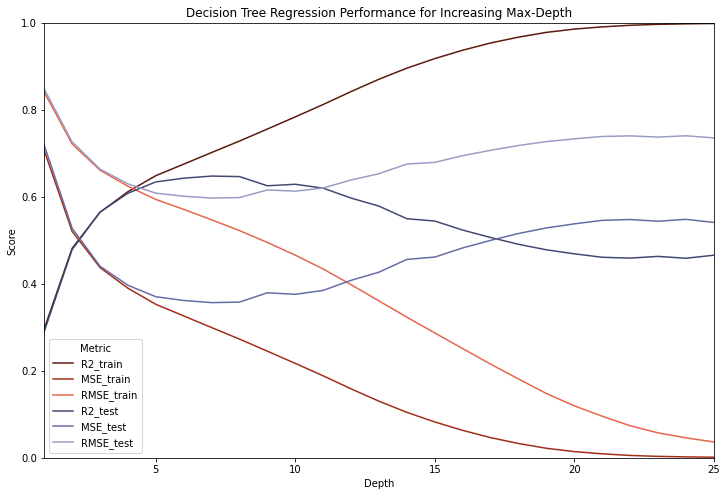

In [120]:
plt.figure(figsize=(12,8))
plt.title("Decision Tree Regression Performance for Increasing Max-Depth")
palette = {"R2_train":"#5A190C",
           "MSE_train":"#A22D16",
           "RMSE_train":"#E7654B",
           "R2_test":"#424874",
           "MSE_test":"#646BA6",
           "RMSE_test":"#979DC3",}
sns.lineplot(
    data=pd.melt(depths_df, ['Depth'], var_name="Metric", value_name="Score"), 
    x='Depth', y='Score', 
    hue='Metric',
    palette=palette,
)
plt.xlim(1, 25)
plt.ylim(0, 1)
plt.show()

If we only look at the training results (red shades) we can see that as max tree depth increases, the performance increases with near-perfect results  (R2 of 1 and MSE/RMSE of 0) occuring at depths over 20. This makes sense as the added depth increases the complexity of the model allowing more xomplex relationships to be learned.

However looking at the testing results (blue shades) we can see the model is clearly overfitting due to the separation of results between the training and testing sets. If we wish to maximise R2 (on unseen data) it seems a max depth somewhere between 4 and 8 would be ideal, for the testing data this seems to be 6 or 7. Max depths below 4 are underfitting and over 8 there is a lot over overfitting.

### Hyperparameter Optimisation

In [128]:
max_features = ['auto', 'sqrt', 'log2']
max_depth = np.arange(3, 10)
min_samples_split = np.arange(2, 10)
min_samples_leaf = np.arange(1, 10)

param_grid = {
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

reg_tree_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
reg_tree_search.fit(X_train, y_train)
reg_tree_search.best_params_

{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 9,
 'min_samples_split': 2}

In [129]:
reg_metrics(reg_tree_search.best_estimator_, "best_estimator", X_test, y_test)

best_estimator regression R2:   0.6533
best_estimator regression MSE:  0.3512
best_estimator regression RMSE: 0.5927


[0.6533299155299052, 0.35123527676223054, 0.5926510581803011]

### Decision Tree Visualisation

As the depth of the optimised decision tree is quite high I shall reduce it for the visualisation so it is easier to view.

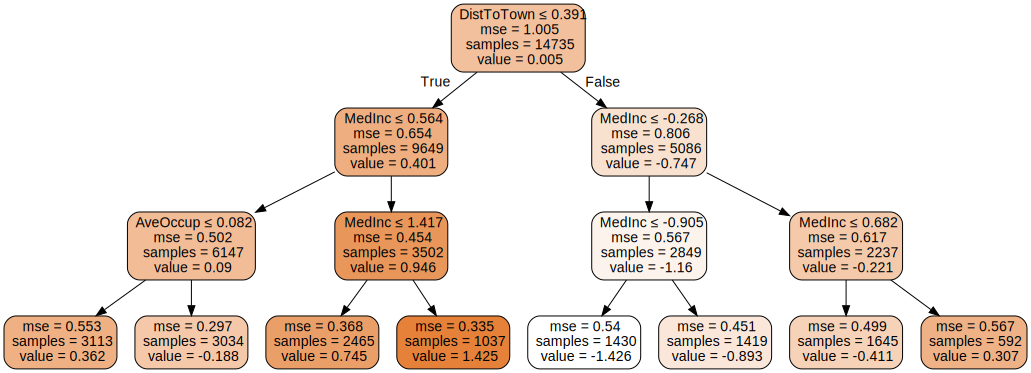

In [144]:
smaller_tree = DecisionTreeRegressor(
    max_depth=3,
    max_features='auto',
    min_samples_leaf=9,
    min_samples_split=2
)
smaller_tree.fit(X_train, y_train)

dot_data = export_graphviz(
    smaller_tree, 
    out_file=None, 
    feature_names=X_train.columns, 
    class_names=y_train.columns, 
    filled=True, 
    rounded=True, 
    special_characters=True
)  

graph = graphviz.Source(dot_data)
graph.render()
display(graph)

The CART algorithm has decided distance to nearest town as being the most deciding feature in the dataset. Median income seems to be the next most important being used all other nodes apart from one with average occupancy. These results align with my analysis of feature correlation after feature engineering, showing that the `DistToTown` and `MedInc` are the most correlated with median house value. These findings seem to make sense as housing is more expensive in cities and towns and people with higher income would be expected to have a more expensive house.

---

## 2.4.2 Boosting

This part adapts the Adaboost method from lab 7 to the MNIST classification task. First, implement and test Adaboost on the MNIST dataset. Use a decision tree as your base classifier. You can use either your implementation from lab 7 or the AdaBoostClassifier class from Scikit-learn. Next, analyse key hyperparameters: the depth of the decision tree and number of estimators (base classifiers) in the ensemble.

In the report, please include the following points:

1. Explain the intuition behind the Adaboost approach (you don’t need to provide all the steps or all the equations).
2. Describe your results and compare them to those from the ANN and SVM.
3. Plot the relationship between the maximum depth of the decision tree and the performance of the ensemble.
4. Explain the effects of other hyperparameters, such as the number of estimators and learning rate.
5. What do you think is a good choice for the number of estimators on this dataset?
6. How much does the ensemble improve performance over a single base classifier?

Download, normalise and create MNIST train, validation and test sets.

In [2]:
X, y = fetch_openml('mnist_784', return_X_y=True)
X_full = X / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

### Decision Tree Classification

In [3]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)
clf_tree.score(X_test, y_test)

0.8692142857142857

Find optimised decision tree classifier.

In [ ]:
max_features = ['auto', 'sqrt', 'log2']
max_depth = np.arange(3, 10)
min_samples_split = np.arange(2, 10)
min_samples_leaf = np.arange(1, 10)

param_grid = {
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

clf_tree_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf_tree_search.fit(X_train, y_train)
clf_tree_search.best_params_

In [ ]:
clf_tree.best_score_

### AdaBoost



In [ ]:
adaboost = AdaBoostClassifier(DecisionTreeClassifier())
adaboost.fit(X_train, y_train)

In [ ]:
adaboost.score(X_test, y_test)

### Ensemble Depth

In [ ]:
depths = [2, 5, 8, 11, 14, 17, 20]
depths_df = pd.DataFrame([], columns=["Depth", "Accuracy_train", "Accuracy_test"])

for depth in depths:
    print(f"Fitting depth {depth}...")
    depth_tree = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth))
    depth_tree.fit(X_train, y_train)
    metrics = [
        depth,
        depth_tree.score(X_train, y_train),
        depth_tree.score(X_test, y_test),
    ]
    depths_df.loc[len(depths_df)] = metrics

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Decision Tree Regression Performance for Increasing Max-Depth")
palette = {
    "Accuracy_train":"#5A190C",
    "Accuracy_test":"#424874",
}
sns.lineplot(
    data=pd.melt(depths_df, ['Depth'], var_name="Metric", value_name="Score"), 
    x='Depth', y='Score', 
    hue='Metric',
    palette=palette,
)
plt.xlim(1, 25)
plt.ylim(0, 1)
plt.show()

### Hyperparameter Optimisation

In [ ]:
n_estimators = [50, 100, 250, 500]
learning_rate = [1, 2, 5, 10]

param_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
}

clf_tree_search = GridSearchCV(DecisionTreeClassifier(max_depth=), param_grid, cv=3)
clf_tree_search.fit(X_train, y_train)
clf_tree_search.best_params_